In [17]:
#import required packages
import flopy
import os
import sys 
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import flopy.utils.binaryfile as bf
import config
%matplotlib inline

<hr/>

### Open MF6 and explore packages

In the following cell, the already created flow packages using ModelMuse are loaded in FloPy. 

In [18]:
simWs = "../scenario2/output" #simulation workspace
name = "pumping" # model name
simName = 'pumping' # simulation name
modelWs = '../scenario2/input' #modelmuse workspace
exeName = '../Exe/mf6.exe'
modelMuse = flopy.mf6.MFSimulation.load(sim_name=simName,exe_name=exeName, sim_ws=modelWs)

gwf_name = name 
gwf = modelMuse.get_model() 

perd = 0
sp = [(3600.0, 120.0, 1.0)] # simulation time = 20 years or 7200 days, # time steps = 240, one stress period.

porosity = 0.3 # effective porosity

diff_coef = 0.7 # diffusion coefficient
long_disp = 10 # longitudinal dispersivity
transH_disp = 0.1 # transversal horizontal dispersivity
transV_disp = 0.01 # transversal vertical dispersivity

paf = r"D:\Thesis\Model\scenario2\output"

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package oc...
    loading package wel...
    loading package riv...
    loading package rch...
    loading package evt...
  loading ims package 'modflow'...


<hr/>

### Flow Model (GWF)

Here, all the flow packages are opened and desirebly modified to fit model status. 

In [19]:
def hydraulicModel(sim, mdMuse):
    
    #define groundwater flow model
    gwModel = flopy.mf6.ModflowGwf(
                                    sim,
                                    modelname=name,
                                    model_nam_file=f'{name}.nam',
                                    newtonoptions = 'UNDER_RELAXATION',
                                    save_flows=True,
                                )
    
    
    #define model discretisation the same as created in ModelMuse
    dismuse = mdMuse.get_package('DIS') 
    dis = flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(
            gwModel,
            pname='dis',
            nlay=dismuse.nlay.array,
            nrow=dismuse.nrow.array,
            ncol=dismuse.ncol.array,
            delr=dismuse.delr.array,
            delc=dismuse.delc.array,
            top=dismuse.top.array,
            botm=dismuse.botm.array,
            idomain=dismuse.idomain.array,            
            xorigin=dismuse.xorigin.array,
            yorigin=dismuse.yorigin.array,
            length_units=dismuse.length_units.array,
            angrot=dismuse.angrot.array
            )
    
    
    #define initial condition for GWF model (model top considered as the initial hydraulic head)
    ic_strt = mdMuse.get_package('IC').strt.array 
    ic = flopy.mf6.modflow.mfgwfic.ModflowGwfic(
                                gwModel,
                                pname='ic',
                                strt=ic_strt,
            )
    
    
    gwf_npf = mdMuse.get_package('NPF')
    h_c = gwf_npf.k.array # hydraulic conductivity read from modelMuse
    hc = flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf(
                                gwModel,
                                pname='npf',
                                icelltype=1, # unconfined aquifer 
                                k=h_c,       # horizontal hydraulic conductivity 
                                k22=h_c,   
                                k33=h_c/10,  # vertical hydraulic conductivity
                                save_flows=True,                                                                                                                
                                save_specific_discharge=True,
                                save_saturation=True,
                            )
    
    
    st = flopy.mf6.ModflowGwfsto(
            gwModel,
            iconvert=1,
            sy=0.2,
            ss=1e-06,
            steady_state={0: True}, # steady-state GWF model
            )     
    
    
    # Riv-Package was used to simulate Maharlu lake.              
    gwf_riv = mdMuse.get_package('RIV-1') 
    riv_rec = gwf_riv.stress_period_data.array[0]
    newRiv_rec = [];
    for i in range(len(riv_rec)):
        riv_rec[i][4] = 189    # constant Cl concentration of 189,000 mg/l or 189 kg/m3 representing the lake
    riv = flopy.mf6.ModflowGwfriv(
                                            model=gwModel,
                                            save_flows=True,
                                            pname="riv",
                                            print_flows=True,
                                            stress_period_data=riv_rec,
                                            maxbound=len(riv_rec),
                                            auxiliary="CONCENTRATION",
                                        )
    
    
    # WEL-Package is used to simulate both withdrawal and injection
    gwf_well = mdMuse.get_package('WEL-1')
    abs_wells = gwf_well.stress_period_data.array[0]
    well = flopy.mf6.ModflowGwfwel(
                                            gwModel,
                                            pname='wel',
                                            print_input=True,
                                            print_flows=True,                              
                                            stress_period_data=abs_wells,                              
                                            save_flows=False,
                                            maxbound=len(abs_wells),
                                            auxiliary="CONCENTRATION",
                                        )
    
    
    #RCH-Package is used to simulate groundwater recharge 
    gwf_rch = mdMuse.get_package('RCH-1') 
    rchs = gwf_rch.stress_period_data.array[0]
    flopy.mf6.ModflowGwfrch(
                                                gwModel,
                                                save_flows=True,
                                                print_flows=True,
                                                print_input=True,
                                                pname="rch",
                                                stress_period_data=rchs,
                                                maxbound=len(rchs)
                                            )
    
    
    
    #Evapotranspiration (EVT) Package 
    gwf_evt = mdMuse.get_package('EVT-1')
    evtp = gwf_evt.stress_period_data.array[0] 
    flopy.mf6.ModflowGwfevt(
                                                gwModel,
                                                save_flows=True,
                                                print_flows=True,
                                                print_input=True,
                                                pname="evt",
                                                stress_period_data=evtp,
                                                maxbound=len(evtp), 
                                                auxiliary="CONCENTRATION",
                                            )
    
    
    #BUY-Package is used to simulate variable-density flow
    pdata = [(0, 1.164, 0, name+"_tp", 'CONCENTRATION')] 
    buy = flopy.mf6.ModflowGwfbuy(
                                    gwModel,
                                    hhformulation_rhs='HHFORMULATION_RHS',
                                    denseref=1000, 
                                    nrhospecies=1,
                                    packagedata=pdata,
                                 )
    
    
    #define output control for GWF model
    oc = flopy.mf6.ModflowGwfoc(
                                    gwModel,
                                    pname='oc',
                                    budget_filerecord=f'{name}.bud',
                                    head_filerecord=f'{name}.bhd',
                                    headprintrecord=[('COLUMNS', 10, 'WIDTH', 15,'DIGITS', 6, 'GENERAL')],
                                    saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                                    printrecord=[('HEAD', 'FIRST'), ('HEAD', 'LAST'), ('BUDGET', 'LAST')]
                                )
    
    
    
    return gwModel

<hr/>

### Transport Model (GWT)

Here, the coupled trasnport model is created.

In [20]:
def tpModel(mdMuse, sim):
    tpname = name + "_tp"
    dismuse = mdMuse.get_package('DIS') # get DIS model from ModelMuse
    
    # import Cl concentration data as the initial condition for GWT model
    initial_conc = pd.read_csv("../scenario2/input/strt_conc.dat", header=None, sep=" ")
    cols = initial_conc.columns
    initial_conc = initial_conc[cols[-1]].values
    grid_conc = np.zeros((dismuse.nlay.array, dismuse.nrow.array, dismuse.ncol.array))
    
    
    # define groundwater transport model
    gwtModel = flopy.mf6.ModflowGwt(
            sim,
            modelname=tpname,
            model_nam_file=f"{tpname}.nam",
        )
    
    
    #define model discretisation the same as defined for GWF model
    dis = flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(
            gwtModel,
            pname='dis',
            nlay=dismuse.nlay.array,
            nrow=dismuse.nrow.array,
            ncol=dismuse.ncol.array,
            delr=dismuse.delr.array,
            delc=dismuse.delc.array,
            top=dismuse.top.array,
            botm=dismuse.botm.array,
            idomain=dismuse.idomain.array,            
            xorigin=dismuse.xorigin.array,
            yorigin=dismuse.yorigin.array,
            length_units=dismuse.length_units.array,
            angrot=dismuse.angrot.array
            )

    for k in range(dismuse.nlay.array):
        pos = 0
        for i in range(dismuse.nrow.array):
            for j in range(dismuse.ncol.array):
                grid_conc[k, i, j] = initial_conc[pos]
                pos += 1

                
    #define initial condition for GWT model (initial cl concentration already imported)
    flopy.mf6.ModflowGwtic(
            gwtModel, strt=grid_conc, filename=f"{tpname}.ic"
        )
    
    
    #define advection
    flopy.mf6.ModflowGwtadv(
            gwtModel, scheme="UPSTREAM", filename=f"{tpname}.adv"
        )
    
    
    #define dispersion
    flopy.mf6.ModflowGwtdsp(
                gwtModel,
                diffc=diff_coef, 
                alh=long_disp, 
                ath1=transH_disp,
                atv=transV_disp,
                filename=f"{tpname}.dsp",
            )
    
    
    #Mobile Storage and Transfer (MST) Package
    flopy.mf6.ModflowGwtmst(
            gwtModel,
            porosity=porosity,            
            filename=f"{tpname}.mst",
            first_order_decay=False,
            pname="mst"
        )

    
    #define sources and sinks
    sourcerecarray = [
        ("riv", "AUX", "CONCENTRATION"),
        ("wel", "AUX", "CONCENTRATION"),
        ("evt", "AUXMIXED", "CONCENTRATION"),
    ]
    flopy.mf6.ModflowGwtssm(
            gwtModel, sources=sourcerecarray, filename=f"{tpname}.ssm"
        )
    
    
    #define output constrol for GWT model
    flopy.mf6.ModflowGwtoc(
                                    gwtModel,
                                    pname='oc',
                                    budget_filerecord=f'{tpname}.cbc',
                                    concentration_filerecord=f'{tpname}.ucn',
                                    concentrationprintrecord=[('COLUMNS', 10, 'WIDTH', 15,'DIGITS', 6, 'GENERAL')],
                                    saverecord=[('CONCENTRATION', 'ALL'), ('BUDGET', 'ALL')],
                                    printrecord=[('CONCENTRATION', 'FIRST'), ('CONCENTRATION', 'LAST'), ('BUDGET', 'LAST')]
                            )
    
    stressPd = [
                ("GWFHEAD", os.path.join(paf, f"{name}.bhd")),
                ("GWFBUDGET", os.path.join(paf, f"{name}.bud")),
            ]
        
        
    #Flow Model Interface (FMI) Package
    flopy.mf6.ModflowGwtfmi(gwtModel, packagedata=stressPd)
    
    return gwtModel

<hr/>

### Write and run simulation

In [21]:
def runModel(mdMuse):
   
    sim = flopy.mf6.MFSimulation(
        sim_name=name,
        version='mf6',
        exe_name=exeName,
        sim_ws=simWs,
        continue_=True,
    )
   
    for prd in range(perd):
        sp.append((30, 120, 1.0))  
    tdis_rc = tuple(sp)
    nperd = len(sp)
    tdis = flopy.mf6.ModflowTdis(
        sim,
        time_units='days',
        nper=nperd,
        perioddata=tdis_rc,
    )

    gw_flow_model = hydraulicModel(
                                    sim=sim,
                                    mdMuse=mdMuse
                                    )
    gw_trans_model = tpModel(mdMuse, sim)
    
    
    #define solver for GWF model
    ims = flopy.mf6.ModflowIms(sim, print_option='SUMMARY',
                                outer_dvclose=1e-3, no_ptcrecord='ALL',
                                outer_maximum=700, under_relaxation='NONE',
                                inner_maximum=300, inner_dvclose=1e-4,
                                linear_acceleration='BICGSTAB',
                                scaling_method='NONE',
                                reordering_method='NONE',
                                relaxation_factor=0.97,
                                rcloserecord=1e-2, filename=f'{gw_flow_model.name}.ims')
    
    #define solver for GWF model (in this method, two solver packages need to be defined for GWF and GWT)
    tp_ims = flopy.mf6.ModflowIms(sim, print_option='SUMMARY',
                            outer_dvclose=1e-3, no_ptcrecord='ALL',
                            outer_maximum=700, under_relaxation='NONE',
                            inner_maximum=300, inner_dvclose=1e-4,
                            linear_acceleration='BICGSTAB',
                            scaling_method='NONE',
                            reordering_method='NONE',
                            relaxation_factor=0.97,     
                            rcloserecord=1e-2, filename=f'{gw_trans_model.name}.ims')
    
    
    #define exchange package in order to exchange information between the GWF and GWT 
    gwfgwt = flopy.mf6.ModflowGwfgwt(sim, exgtype='GWF6-GWT6',
                                 exgmnamea=gw_flow_model.name, exgmnameb=gw_trans_model.name,
                                )
    
    sim.register_ims_package(ims, [gw_flow_model.name])
    
    sim.register_ims_package(tp_ims, [gw_trans_model.name])
    
    sim.write_simulation(silent=True)
    success, buff = sim.run_simulation()
    if success:
        print("model run complete")
        
    return sim

In [22]:
simRun=runModel(gwf)

FloPy is using the following executable to run the model: ../Exe/mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.3.0 03/04/2022

   MODFLOW 6 compiled Mar 02 2022 15:29:04 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.5.0
                             Build 20211109_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be

<hr/>

### Import and plot results

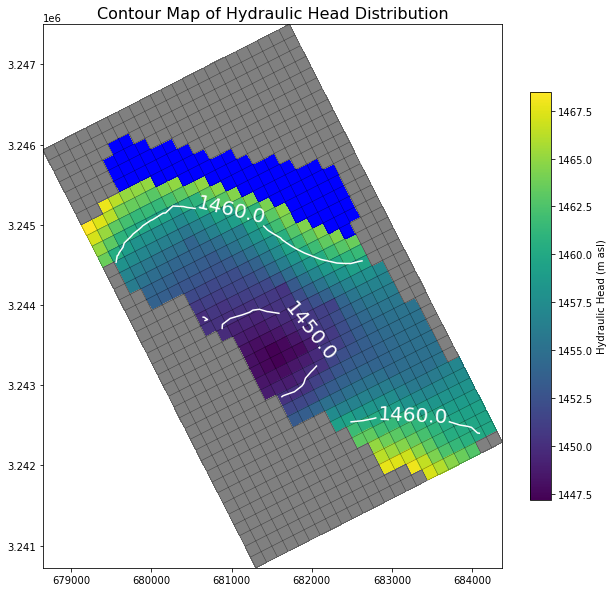

In [16]:
gwf = simRun.get_model("pumping")
gwt = simRun.get_model("pumping_tp")

hd_pth = gwf.oc.head_filerecord.get_data()[0][0]
full_hd_pth = os.path.join(simWs, hd_pth)      
hds = flopy.utils.binaryfile.HeadFile(full_hd_pth)

kstpkper = hds.get_kstpkper()[-1]
h = hds.get_data(kstpkper=kstpkper)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_title("Contour Map of Hydraulic Head Distribution", fontsize=16)

mapview = flopy.plot.PlotMapView(model=gwf, ax=ax)
linecollection = mapview.plot_grid(lw=0.5, color="black", alpha = 0.5) 
ar_plot = mapview.plot_array(h, masked_values=(0, 1e30, -1e30))

contours = mapview.contour_array(h, colors="white", linewidths=1.5, masked_values=(0, 1e30, -1e30),
                                  levels = [1420, 1430, 1440, 1450, 1460]
                                )

riv_plot = mapview.plot_bc("riv", color='blue') # maharlu lake
#wel_plot = mapview.plot_bc("wel", color='red')
in_active = mapview.plot_inactive(color_noflow="0.5")
cb = plt.colorbar(ar_plot, shrink=0.75, fraction=0.05, label="Hydraulic Head (m asl)")
plt.clabel(contours, fmt='%2.1f', fontsize=20)
#plt.savefig("../fig/head.png", format = 'png')

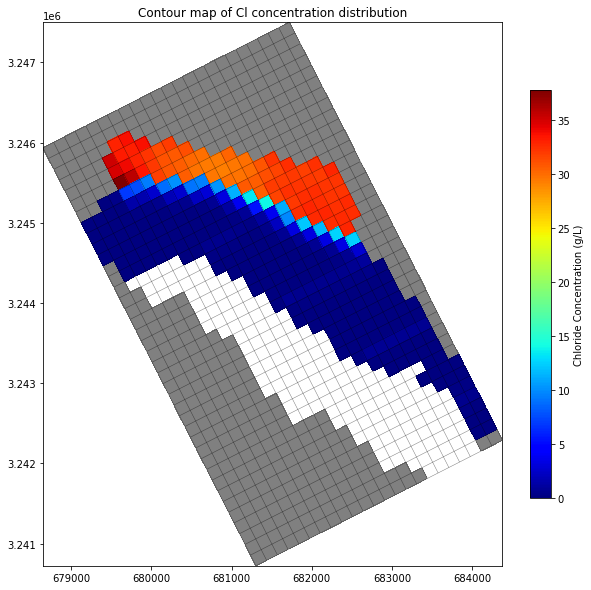

In [8]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_title("Contour map of Cl concentration distribution")

mapview = flopy.plot.PlotMapView(model=gwf, ax=ax)
linecollection = mapview.plot_grid(lw=0.5, color="black", alpha = 0.5)

in_active=mapview.plot_inactive(color_noflow="0.5") # inactive cells

fname = os.path.join(simWs, f"{gwt.name}.ucn")
conc_fl = flopy.utils.HeadFile(fname, text="concentration", precision="double")

prd = conc_fl.get_kstpkper()[-1]
c = conc_fl.get_data(kstpkper=prd)

cr_plot = mapview.plot_array(c, cmap="jet", masked_values=(0, 1e30, -1e30))
cb = plt.colorbar(cr_plot, shrink=0.75, fraction=0.05, label="Chloride Concentration (g/L)")
#contours = mapview.contour_array(c, colors="white", linewidths=1.5, masked_values=(0, 1e30, -1e30), levels = [0.5, 1, 2, 3, 10, 20, 200])

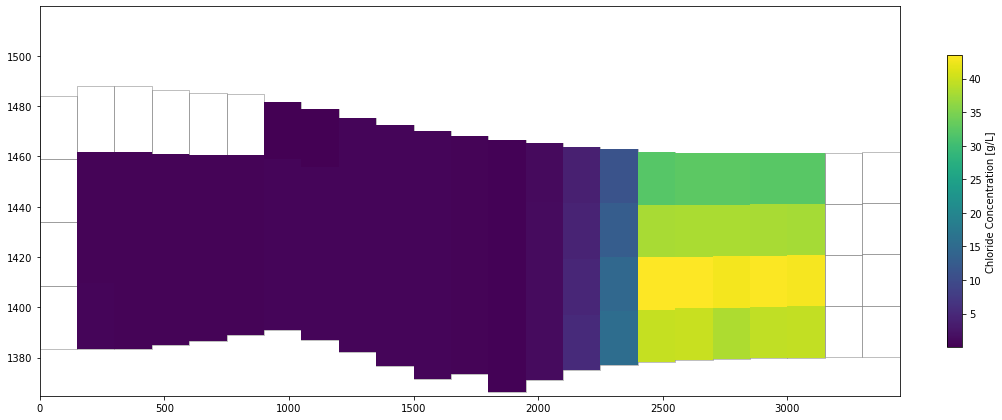

In [24]:
#plot cross section

fig, ax = plt.subplots(figsize=(14,6))
fig.tight_layout()
crossview = flopy.plot.PlotCrossSection(model=gwf, ax=ax, line={'row':13})
crossview.plot_grid(alpha=0.5)

#in_active=crossview.plot_inactive(color_noflow="0.5")

# get MODFLOW 6 concentration
conc = gwt.output.concentration().get_data()

crsv=crossview.plot_array(conc, masked_values=(0, 1e30, -1e30))
cb=plt.colorbar(crsv, shrink=0.75, fraction=0.05, label="Chloride Concentration [g/L]")